## Jupyter notebook for plotting the clusters between linked CHi-C, ATAC-seq and RNA-seq

This notebook is the code for plotting the clusters between linked CHi-C, ATAC-seq and RNA-seq time course data (Supplementary Fig. 5a-f) illustrated in the paper **"Simultaneous analysis of open chromatin, promoter interactions and gene expression in stimulated T cells implicates causal genes for rheumatoid arthritis"** by Jing Yang, Amanda McGovern, Paul Martin, Kate Duffus, Peyman Zarrineh, Andrew P Morris, Antony Adamson, Peter Fraser, Magnus Rattray & Stephen Eyre 

Author : *Jing Yang*  <br />
Date: 24-10-2019 <br />
For any questions about the code, please drop me a line at Jing.Yang@manchester.ac.uk

### loading required packages

In [1]:
library(ggplot2)
library(gridExtra)

### load the data of linked CHi-C, ATAC-seq and RNA-seq within 200 kb of promoters. 
Differences between Bayesian information criteria of a dynamic Gaussian Process model and a noise model are also included in the file. 

In [2]:
data_200k <- read.table('data/data_within200k_withBIC.txt', header=T)

In [3]:
idx_gene <- c('ET0_a','ET20_a','ET1H_a','ET2H_a','ET4H_a','ET24H_a')
idx_atacseq <- c('AT0','AT20','AT1H','AT2H','AT4H','AT24H')
idx_chic <- c('T0','T20','T1H','T4H','T24H')

### preparing data for the case with both CHi-C and ATAC-seq being dynamic

In [4]:
idx <- data_200k$BIC_chic<0 & data_200k$BIC_atacseq<0
data_200k_dynamic <- data_200k[idx,]
time <- c('0m','20m','1hr','2hr','4hr','24hr') ### time points for the plotting

### cluster gene data first

In [5]:
data1_ENSG <- unique(data_200k_dynamic[,c('ENSG',idx_gene)])
data1_gene <- data1_ENSG[,idx_gene]
data1_gene_normalized <- t(scale(t(data1_gene), center=TRUE, scale=TRUE))
data_cluster <- data1_gene_normalized

set.seed(5)
CLUSTER_SIZE = 4
kmeans_cluster <- kmeans(data_cluster,centers=CLUSTER_SIZE,iter.max = 100)
cluster_freq <- as.data.frame(table(kmeans_cluster$cluster))
names(cluster_freq) <- c('x','freq')
cl <- cluster_freq[with(cluster_freq,order(-cluster_freq[,'freq'])),]

stepsize <- 4
kk <- 1
M <- kk:(kk+stepsize-1)
clusters_picked <- cl$x[M]
clusters_frequency <- cl$freq[M]
centers_picked <- kmeans_cluster$center[clusters_picked,]
idx <- numeric(0)

data_forillus <- numeric(0)
for (ii in 1:length(M)){
    idx <- which(kmeans_cluster$cluster==clusters_picked[ii]) 
    data_forillus <- c(data_forillus,c(t(data_cluster[idx,])))
}

### plot gene clustering results first

In [6]:
data_forplot <- data.frame(x=rep(time, sum(clusters_frequency)), y=data_forillus, 
                           group_time = rep(1:((sum(clusters_frequency))),each=length(time)),
                           group_cluster = rep(M,clusters_frequency*length(time)),
                           group_label = rep(c(rep('gene',6)), sum(clusters_frequency)),
                           group_frequency = rep(clusters_frequency, clusters_frequency*length(time)))

data_forplot$x_f <- factor(data_forplot$x, levels=c('0m','20m','1hr','2hr','4hr','24hr'))

p_gene1 <- ggplot(data=subset(data_forplot, data_forplot$group_cluster %in% '1'), aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_cluster)) + geom_line(color='blue')+
   labs(x ="Time", y = "Gene") + 
   theme(panel.background=element_blank(), axis.title.x=element_blank(),axis.text.x=element_blank(), axis.ticks.x=element_blank(), 
         axis.line=element_line(),strip.background = element_blank(), strip.text = element_blank(),
         axis.text.y=element_text(size=14, face='bold'),axis.title.y=element_text(size=18,face="bold"), legend.position="none") +
   facet_grid(.~group_label)

p_gene2 <- ggplot(data=subset(data_forplot, data_forplot$group_cluster %in% '2'), aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_cluster)) + geom_line(color='blue')+
   labs(x ="Time", y = "Gene") +  
   scale_x_discrete(breaks=c('0m','1hr','24hr'),labels=c("0m","1hr","24hr")) + 
   theme(panel.background=element_blank(), plot.title = element_text(hjust = 0.5, face='bold'), 
         axis.line=element_line(),strip.background = element_blank(), strip.text.x = element_blank(),
         axis.text=element_text(size=16, face='bold'),axis.title=element_text(size=18,face="bold"), legend.position="none") +
   facet_grid(.~group_label)

p_gene3 <- ggplot(data=subset(data_forplot, data_forplot$group_cluster %in% '3'), aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_cluster)) + geom_line(color='blue')+
   labs(x ="Time", y = "Gene") + 
   theme(panel.background=element_blank(), axis.title.x=element_blank(),axis.text.x=element_blank(), axis.ticks.x=element_blank(), 
         axis.line=element_line(),strip.background = element_blank(), strip.text = element_blank(),
         axis.text.y=element_text(size=14, face='bold'),axis.title.y=element_text(size=18,face="bold"), legend.position="none") +
   facet_grid(.~group_label)

p_gene4 <- ggplot(data=subset(data_forplot, data_forplot$group_cluster %in% '4'), aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_cluster)) + geom_line(color='blue')+
   labs(x ="Time", y = "Gene") + 
   scale_x_discrete(breaks=c('0m','1hr','24hr'),labels=c("0m","1hr","24hr")) + 
   theme(panel.background=element_blank(), plot.title = element_text(hjust = 0.5, face='bold'), 
         axis.line=element_line(),strip.background = element_blank(), strip.text.x = element_blank(),
         axis.text=element_text(size=16, face='bold'),axis.title=element_text(size=18,face="bold"), legend.position="none") +
   facet_grid(.~group_label)

### saving gene cluster results

In [7]:
data1_ENSG$gene_cluster <- kmeans_cluster$cluster

data_200k_dynamic_withgenecluster <- unique(merge(data1_ENSG[,c('ENSG','gene_cluster')], data_200k_dynamic))
data_200k_dynamic_genecluster1 <- subset(data_200k_dynamic_withgenecluster, data_200k_dynamic_withgenecluster$gene_cluster %in% '1')
data_200k_dynamic_genecluster2 <- subset(data_200k_dynamic_withgenecluster, data_200k_dynamic_withgenecluster$gene_cluster %in% '2')
data_200k_dynamic_genecluster3 <- subset(data_200k_dynamic_withgenecluster, data_200k_dynamic_withgenecluster$gene_cluster %in% '3')
data_200k_dynamic_genecluster4 <- subset(data_200k_dynamic_withgenecluster, data_200k_dynamic_withgenecluster$gene_cluster %in% '4')


### start clustering CHi-C data

In [8]:
data1_chic_original1 <- unique(data_200k_dynamic_genecluster1[,c('baitID','otherEndID',idx_chic)])
data1_chic_original2 <- unique(data_200k_dynamic_genecluster2[,c('baitID','otherEndID',idx_chic)])
data1_chic_original3 <- unique(data_200k_dynamic_genecluster3[,c('baitID','otherEndID',idx_chic)])
data1_chic_original4 <- unique(data_200k_dynamic_genecluster4[,c('baitID','otherEndID',idx_chic)])

data1_chic1 <- data1_chic_original1[,idx_chic]
data1_chic2 <- data1_chic_original2[,idx_chic]
data1_chic3 <- data1_chic_original3[,idx_chic]
data1_chic4 <- data1_chic_original4[,idx_chic]

data1_chic1_normalized <- t(scale(t(data1_chic1), center=TRUE, scale=TRUE))
data1_chic2_normalized <- t(scale(t(data1_chic2), center=TRUE, scale=TRUE))
data1_chic3_normalized <- t(scale(t(data1_chic3), center=TRUE, scale=TRUE))
data1_chic4_normalized <- t(scale(t(data1_chic4), center=TRUE, scale=TRUE))

time_chic <- c('0m','20m','1hr','4hr','24hr')



### clustering and plotting CHi-C data

In [9]:
data_cluster_chic1 <- data1_chic1_normalized

set.seed(5)
CLUSTER_SIZE = 4
kmeans_cluster <- kmeans(data_cluster_chic1,centers=CLUSTER_SIZE,iter.max = 100)
cluster_freq <- as.data.frame(table(kmeans_cluster$cluster))
names(cluster_freq) <- c('x','freq')
cl <- cluster_freq[with(cluster_freq,order(-cluster_freq[,'freq'])),]

stepsize <- 4
kk <- 1
M <- kk:(kk+stepsize-1)
clusters_picked <- cl$x[M]
clusters_frequency <- cl$freq[M]
centers_picked <- kmeans_cluster$center[clusters_picked,]
idx <- numeric(0)

data_forillus <- numeric(0)
    
for (ii in 1:length(M)){
    idx <- which(kmeans_cluster$cluster==clusters_picked[ii]) 
    data_forillus <- c(data_forillus,c(t(data_cluster_chic1[idx,])))
}

data_forplot <- data.frame(x=rep(time_chic, sum(clusters_frequency)), y=data_forillus, 
                           group_time = rep(1:((sum(clusters_frequency))),each=length(time_chic)),
                           group_cluster = rep(M,clusters_frequency*length(time_chic)),
                           group_label = rep(c(rep('CHi-C',length(time_chic))), sum(clusters_frequency)),
                           group_frequency = rep(clusters_frequency, clusters_frequency*length(time_chic)))
data_forplot$x_f <- factor(data_forplot$x, levels=c('0m','20m','1hr','4hr','24hr'))


p_chic1 <- ggplot(data=data_forplot, aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_label)) + geom_line(color='green')+
   labs( x ="Time", y = "CHi-C") + 
   scale_x_discrete(breaks=c('0m','4hr'),labels=c("0m","4hr")) + 
   theme(panel.background=element_blank(), axis.title.x=element_blank(),axis.text.x=element_blank(), axis.ticks.x=element_blank(), 
         axis.line=element_line(),strip.background = element_blank(), strip.text = element_blank(),
         axis.text.y=element_text(size=14, face='bold'),axis.title.y=element_text(size=18,face="bold"), legend.position="none") +
   facet_wrap(group_cluster~., ncol=2)

data_cluster_chic2 <- data1_chic2_normalized

set.seed(5)
CLUSTER_SIZE = 4
kmeans_cluster <- kmeans(data_cluster_chic2,centers=CLUSTER_SIZE,iter.max = 100)
cluster_freq <- as.data.frame(table(kmeans_cluster$cluster))
names(cluster_freq) <- c('x','freq')
cl <- cluster_freq[with(cluster_freq,order(-cluster_freq[,'freq'])),]

stepsize <- 4
M <- kk:(kk+stepsize-1)
clusters_picked <- cl$x[M]
clusters_frequency <- cl$freq[M]
centers_picked <- kmeans_cluster$center[clusters_picked,]
idx <- numeric(0)

data_forillus <- numeric(0)
    
for (ii in 1:length(M)){
    idx <- which(kmeans_cluster$cluster==clusters_picked[ii]) 
    data_forillus <- c(data_forillus,c(t(data_cluster_chic2[idx,])))
}


data_forplot <- data.frame(x=rep(time_chic, sum(clusters_frequency)), y=data_forillus, 
                           group_time = rep(1:((sum(clusters_frequency))),each=length(time_chic)),
                           group_cluster = rep(M,clusters_frequency*length(time_chic)),
                           group_label = rep(c(rep('CHiC',length(time_chic))), sum(clusters_frequency)),
                           group_frequency = rep(clusters_frequency, clusters_frequency*length(time_chic)))
data_forplot$x_f <- factor(data_forplot$x, levels=c('0m','20m','1hr','4hr','24hr'))


p_chic2 <- ggplot(data=data_forplot, aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_label)) + geom_line(color='green')+
   labs( x ="Time", y = "CHi-C") + 
   scale_x_discrete(breaks=c('0m','4hr'),labels=c("0m","4hr")) + 
theme(panel.background=element_blank(), plot.title = element_text(hjust = 0.5, face='bold'), 
         axis.line=element_line(),strip.background = element_blank(), strip.text.x = element_blank(),
         axis.text=element_text(size=16, face='bold'),axis.title=element_text(size=18,face="bold"), legend.position="none") +   #facet_grid((group_cluster-1) %/%2 ~(group_cluster-1)%%2 )
   facet_wrap(group_cluster~., ncol=2)

data_cluster_chic3 <- data1_chic3_normalized

set.seed(5)
CLUSTER_SIZE = 4
kmeans_cluster <- kmeans(data_cluster_chic3,centers=CLUSTER_SIZE,iter.max = 100)
cluster_freq <- as.data.frame(table(kmeans_cluster$cluster))
names(cluster_freq) <- c('x','freq')
cl <- cluster_freq[with(cluster_freq,order(-cluster_freq[,'freq'])),]

stepsize <- 4
M <- kk:(kk+stepsize-1)
clusters_picked <- cl$x[M]
clusters_frequency <- cl$freq[M]
centers_picked <- kmeans_cluster$center[clusters_picked,]
idx <- numeric(0)

data_forillus <- numeric(0)
    
for (ii in 1:length(M)){
    idx <- which(kmeans_cluster$cluster==clusters_picked[ii]) 
    data_forillus <- c(data_forillus,c(t(data_cluster_chic3[idx,])))
}


data_forplot <- data.frame(x=rep(time_chic, sum(clusters_frequency)), y=data_forillus, 
                           group_time = rep(1:((sum(clusters_frequency))),each=length(time_chic)),
                           group_cluster = rep(M,clusters_frequency*length(time_chic)),
                           group_label = rep(c(rep('CHi-C',length(time_chic))), sum(clusters_frequency)),
                           group_frequency = rep(clusters_frequency, clusters_frequency*length(time_chic)))
data_forplot$x_f <- factor(data_forplot$x, levels=c('0m','20m','1hr','4hr','24hr'))


p_chic3 <- ggplot(data=data_forplot, aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_label)) + geom_line(color='green')+
   labs( x ="Time", y = "CHi-C") + 
   scale_x_discrete(breaks=c('0m','4hr'),labels=c("0m","4hr")) + 
   theme(panel.background=element_blank(), axis.title.x=element_blank(),axis.text.x=element_blank(), axis.ticks.x=element_blank(), 
         axis.line=element_line(),strip.background = element_blank(), strip.text = element_blank(),
         axis.text.y=element_text(size=14, face='bold'),axis.title.y=element_text(size=18,face="bold"), legend.position="none") +
   facet_wrap(group_cluster~., ncol=2)

data_cluster_chic4 <- data1_chic4_normalized

set.seed(5)
CLUSTER_SIZE = 4
kmeans_cluster <- kmeans(data_cluster_chic4,centers=CLUSTER_SIZE,iter.max = 100)
cluster_freq <- as.data.frame(table(kmeans_cluster$cluster))
names(cluster_freq) <- c('x','freq')
cl <- cluster_freq[with(cluster_freq,order(-cluster_freq[,'freq'])),]

stepsize <- 4
M <- kk:(kk+stepsize-1)
clusters_picked <- cl$x[M]
clusters_frequency <- cl$freq[M]
centers_picked <- kmeans_cluster$center[clusters_picked,]
idx <- numeric(0)

data_forillus <- numeric(0)
    
for (ii in 1:length(M)){
    idx <- which(kmeans_cluster$cluster==clusters_picked[ii]) 
    data_forillus <- c(data_forillus,c(t(data_cluster_chic4[idx,])))
}


data_forplot <- data.frame(x=rep(time_chic, sum(clusters_frequency)), y=data_forillus, 
                           group_time = rep(1:((sum(clusters_frequency))),each=length(time_chic)),
                           group_cluster = rep(M,clusters_frequency*length(time_chic)),
                           group_label = rep(c(rep('CHi-C',length(time_chic))), sum(clusters_frequency)),
                           group_frequency = rep(clusters_frequency, clusters_frequency*length(time_chic)))
data_forplot$x_f <- factor(data_forplot$x, levels=c('0m','20m','1hr','4hr','24hr'))


p_chic4 <- ggplot(data=data_forplot, aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_label)) + geom_line(color='green')+
   labs( x ="Time", y = "CHi-C") + 
   scale_x_discrete(breaks=c('0m','4hr'),labels=c("0m","4hr")) + 
theme(panel.background=element_blank(), plot.title = element_text(hjust = 0.5, face='bold'), 
         axis.line=element_line(),strip.background = element_blank(), strip.text.x = element_blank(),
         axis.text=element_text(size=16, face='bold'),axis.title=element_text(size=18,face="bold"), legend.position="none") +   #facet_grid((group_cluster-1) %/%2 ~(group_cluster-1)%%2 )
   facet_wrap(group_cluster~., ncol=2)

### clustering and plotting relevant ATAC-seq data

In [10]:


data1_original <- unique(data_200k_dynamic_genecluster1[, c('ID',idx_atacseq)])
data1 <- data1_original
data1_atacseq <- data1[,idx_atacseq]
data1_atacseq_normalized <- t(scale(t(data1_atacseq), center=TRUE, scale=TRUE))
data_cluster <- data1_atacseq_normalized

set.seed(5)
CLUSTER_SIZE = 6
kmeans_cluster <- kmeans(data_cluster,centers=CLUSTER_SIZE,iter.max = 100)
cluster_freq <- as.data.frame(table(kmeans_cluster$cluster))
names(cluster_freq) <- c('x','freq')
cl <- cluster_freq[with(cluster_freq,order(-cluster_freq[,'freq'])),]

stepsize <- 4
M <- kk:(kk+stepsize-1)
clusters_picked <- cl$x[M]
clusters_frequency <- cl$freq[M]
centers_picked <- kmeans_cluster$center[clusters_picked,]
idx <- numeric(0)

data_forillus <- numeric(0)
data_ENSG <- character(0)
    
time <- c('0m','20m','1hr','2hr','4hr','24hr')
for (ii in 1:length(M)){
    idx <- which(kmeans_cluster$cluster==clusters_picked[ii]) 
    data_forillus <- c(data_forillus,c(t(data_cluster[idx,])))
}


data_forplot <- data.frame(x=rep(time, sum(clusters_frequency)), y=data_forillus, 
                           group_time = rep(1:((sum(clusters_frequency))),each=length(time)),
                           group_cluster = rep(M,clusters_frequency*length(time)),
                           group_label = rep(c(rep('atacseq',6)), sum(clusters_frequency)),
                           group_frequency = rep(clusters_frequency, clusters_frequency*length(time)))
data_forplot$x_f <- factor(data_forplot$x, levels=c('0m','20m','1hr','2hr','4hr','24hr'))


p_atacseq1 <- ggplot(data=data_forplot, aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_label)) + geom_line(color='red')+
   labs( x ="Time", y = "ATAC-seq") + 
   theme(panel.background=element_blank(), axis.title.x=element_blank(),axis.text.x=element_blank(), axis.ticks.x=element_blank(), 
         axis.line=element_line(),strip.background = element_blank(), strip.text = element_blank(),
         axis.text.y=element_text(size=14, face='bold'),axis.title.y=element_text(size=18,face="bold"), legend.position="none") +
   facet_wrap(group_cluster~., ncol=2)

data1_original <- unique(data_200k_dynamic_genecluster2[, c('ID',idx_atacseq)])
data1 <- data1_original
data1_atacseq <- data1[,idx_atacseq]
data1_atacseq_normalized <- t(scale(t(data1_atacseq), center=TRUE, scale=TRUE))
data_cluster <- data1_atacseq_normalized

set.seed(5)
CLUSTER_SIZE = 6
kmeans_cluster <- kmeans(data_cluster,centers=CLUSTER_SIZE,iter.max = 100)
cluster_freq <- as.data.frame(table(kmeans_cluster$cluster))
names(cluster_freq) <- c('x','freq')
cl <- cluster_freq[with(cluster_freq,order(-cluster_freq[,'freq'])),]

stepsize <- 4
M <- kk:(kk+stepsize-1)
clusters_picked <- cl$x[M]
clusters_frequency <- cl$freq[M]
centers_picked <- kmeans_cluster$center[clusters_picked,]
idx <- numeric(0)

data_forillus <- numeric(0)
data_ENSG <- character(0)
    
time <- c('0m','20m','1hr','2hr','4hr','24hr')
for (ii in 1:length(M)){
    idx <- which(kmeans_cluster$cluster==clusters_picked[ii]) 
    data_forillus <- c(data_forillus,c(t(data_cluster[idx,])))
}


data_forplot <- data.frame(x=rep(time, sum(clusters_frequency)), y=data_forillus, 
                           group_time = rep(1:((sum(clusters_frequency))),each=length(time)),
                           group_cluster = rep(M,clusters_frequency*length(time)),
                           group_label = rep(c(rep('atacseq',6)), sum(clusters_frequency)),
                           group_frequency = rep(clusters_frequency, clusters_frequency*length(time)))

data_forplot$x_f <- factor(data_forplot$x, levels=c('0m','20m','1hr','2hr','4hr','24hr'))

p_atacseq2 <- ggplot(data=data_forplot, aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_label)) + geom_line(color='red')+
   labs( x ="Time", y = "ATAC-seq") +  
   scale_x_discrete(breaks=c('0m','4hr'),labels=c("0m","4hr")) + 
theme(panel.background=element_blank(), plot.title = element_text(hjust = 0.5, face='bold'), 
         axis.line=element_line(),strip.background = element_blank(), strip.text.x = element_blank(),
         axis.text=element_text(size=16, face='bold'),axis.title=element_text(size=18,face="bold"), legend.position="none") +   #facet_grid((group_cluster-1) %/%2 ~(group_cluster-1)%%2 )
   facet_wrap(group_cluster~., ncol=2)

data1_original <- unique(data_200k_dynamic_genecluster3[, c('ID',idx_atacseq)])
data1 <- data1_original
data1_atacseq <- data1[,idx_atacseq]
data1_atacseq_normalized <- t(scale(t(data1_atacseq), center=TRUE, scale=TRUE))
data_cluster <- data1_atacseq_normalized

set.seed(5)
CLUSTER_SIZE = 6
kmeans_cluster <- kmeans(data_cluster,centers=CLUSTER_SIZE,iter.max = 100)
cluster_freq <- as.data.frame(table(kmeans_cluster$cluster))
names(cluster_freq) <- c('x','freq')
cl <- cluster_freq[with(cluster_freq,order(-cluster_freq[,'freq'])),]

stepsize <- 4
M <- kk:(kk+stepsize-1)
clusters_picked <- cl$x[M]
clusters_frequency <- cl$freq[M]
centers_picked <- kmeans_cluster$center[clusters_picked,]
idx <- numeric(0)

data_forillus <- numeric(0)
data_ENSG <- character(0)
    
time <- c('0m','20m','1hr','2hr','4hr','24hr')
for (ii in 1:length(M)){
    idx <- which(kmeans_cluster$cluster==clusters_picked[ii]) 
    data_forillus <- c(data_forillus,c(t(data_cluster[idx,])))
}


data_forplot <- data.frame(x=rep(time, sum(clusters_frequency)), y=data_forillus, 
                           group_time = rep(1:((sum(clusters_frequency))),each=length(time)),
                           group_cluster = rep(M,clusters_frequency*length(time)),
                           group_label = rep(c(rep('atacseq',6)), sum(clusters_frequency)),
                           group_frequency = rep(clusters_frequency, clusters_frequency*length(time)))

data_forplot$x_f <- factor(data_forplot$x, levels=c('0m','20m','1hr','2hr','4hr','24hr'))

p_atacseq3 <- ggplot(data=data_forplot, aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_label)) + geom_line(color='red')+
   labs( x ="Time", y = "ATAC-seq") + 
   scale_x_discrete(breaks=c('0m','4hr'),labels=c("0m","4hr")) + 
   theme(panel.background=element_blank(), axis.title.x=element_blank(),axis.text.x=element_blank(), axis.ticks.x=element_blank(), 
         axis.line=element_line(),strip.background = element_blank(), strip.text = element_blank(),
         axis.text.y=element_text(size=14, face='bold'),axis.title.y=element_text(size=18,face="bold"), legend.position="none") +
   facet_wrap(group_cluster~., ncol=2)


data1_original <- unique(data_200k_dynamic_genecluster4[, c('ID',idx_atacseq)])
data1 <- data1_original
data1_atacseq <- data1[,idx_atacseq]
data1_atacseq_normalized <- t(scale(t(data1_atacseq), center=TRUE, scale=TRUE))
data_cluster <- data1_atacseq_normalized

set.seed(5)
CLUSTER_SIZE = 6
kmeans_cluster <- kmeans(data_cluster,centers=CLUSTER_SIZE,iter.max = 100)
cluster_freq <- as.data.frame(table(kmeans_cluster$cluster))
names(cluster_freq) <- c('x','freq')
cl <- cluster_freq[with(cluster_freq,order(-cluster_freq[,'freq'])),]

stepsize <- 4
M <- kk:(kk+stepsize-1)
clusters_picked <- cl$x[M]
clusters_frequency <- cl$freq[M]
centers_picked <- kmeans_cluster$center[clusters_picked,]
idx <- numeric(0)

data_forillus <- numeric(0)
data_ENSG <- character(0)
    
time <- c('0m','20m','1hr','2hr','4hr','24hr')
for (ii in 1:length(M)){
    idx <- which(kmeans_cluster$cluster==clusters_picked[ii]) 
    data_forillus <- c(data_forillus,c(t(data_cluster[idx,])))
}


data_forplot <- data.frame(x=rep(time, sum(clusters_frequency)), y=data_forillus, 
                           group_time = rep(1:((sum(clusters_frequency))),each=length(time)),
                           group_cluster = rep(M,clusters_frequency*length(time)),
                           group_label = rep(c(rep('atacseq',6)), sum(clusters_frequency)),
                           group_frequency = rep(clusters_frequency, clusters_frequency*length(time)))

data_forplot$x_f <- factor(data_forplot$x, levels=c('0m','20m','1hr','2hr','4hr','24hr'))

p_atacseq4 <- ggplot(data=data_forplot, aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_label)) + geom_line(color='red')+
   labs( x ="Time", y = "ATAC-seq") + 
   scale_x_discrete(breaks=c('0m','4hr'),labels=c("0m","4hr")) + 
theme(panel.background=element_blank(), plot.title = element_text(hjust = 0.5, face='bold'), 
         axis.line=element_line(),strip.background = element_blank(), strip.text.x = element_blank(),
         axis.text=element_text(size=16, face='bold'),axis.title=element_text(size=18,face="bold"), legend.position="none") +   #facet_grid((group_cluster-1) %/%2 ~(group_cluster-1)%%2 )
   facet_wrap(group_cluster~., ncol=2)



### put results together and plot them

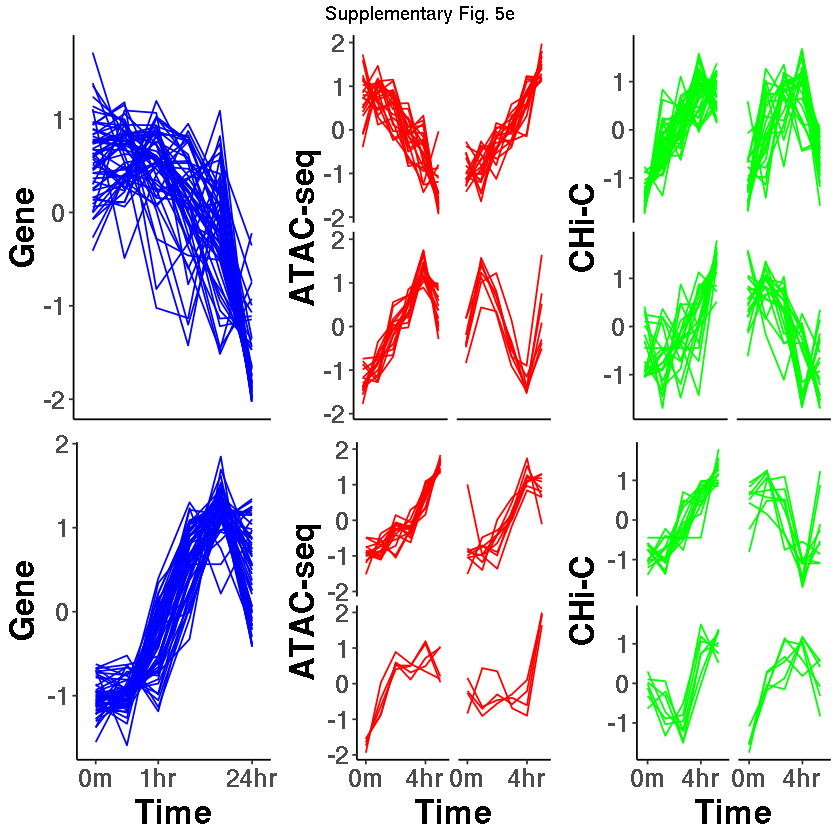

In [11]:

grid.arrange(p_gene1, p_atacseq1, p_chic1, p_gene2, p_atacseq2, p_chic2, ncol=3, top = 'Supplementary Fig. 5e')


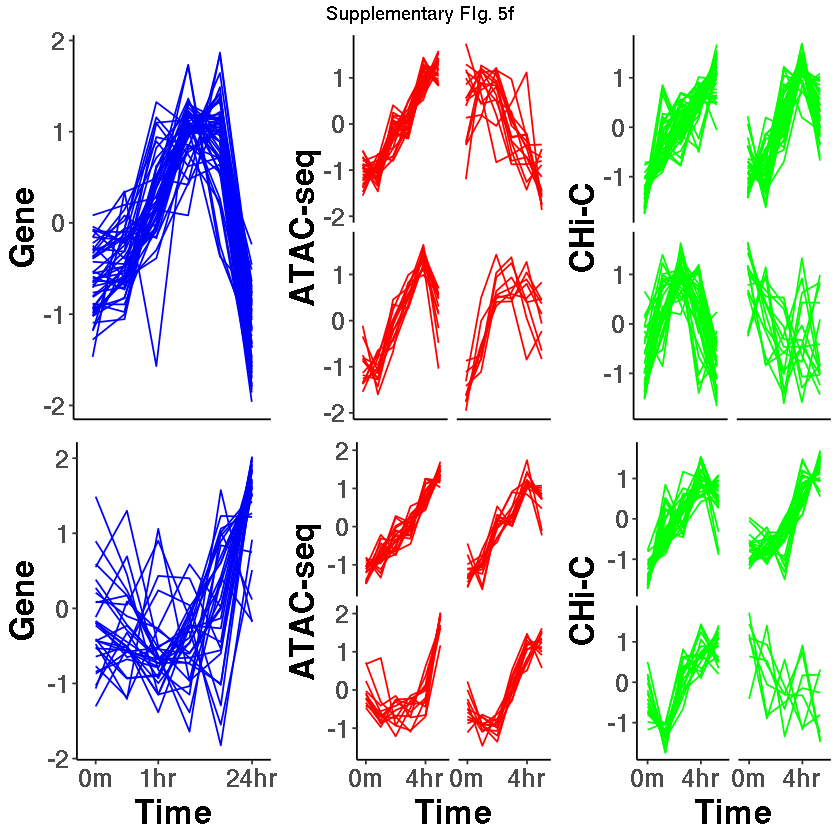

In [12]:
grid.arrange(p_gene3, p_atacseq3, p_chic3, p_gene4, p_atacseq4, p_chic4, ncol=3, top = 'Supplementary FIg. 5f')

### start to work on the case with dynamic CHi-C and static ATAC-seq

In [13]:
idx <- data_200k$BIC_chic<0 & data_200k$BIC_atacseq>0
data_200k_dynamicCHiC <- data_200k[idx,]
time <- c('0m','20m','1hr','2hr','4hr','24hr') ### time points for the plotting

### clustering gene data first

In [14]:
data1_ENSG <- unique(data_200k_dynamicCHiC[,c('ENSG',idx_gene)])
data1_gene <- data1_ENSG[,idx_gene]
data1_gene_normalized <- t(scale(t(data1_gene), center=TRUE, scale=TRUE))
data_cluster <- data1_gene_normalized

set.seed(5)
CLUSTER_SIZE = 4
kmeans_cluster <- kmeans(data_cluster,centers=CLUSTER_SIZE,iter.max = 100)
cluster_freq <- as.data.frame(table(kmeans_cluster$cluster))
names(cluster_freq) <- c('x','freq')
cl <- cluster_freq[with(cluster_freq,order(-cluster_freq[,'freq'])),]

stepsize <- 4
M <- kk:(kk+stepsize-1)
clusters_picked <- cl$x[M]
clusters_frequency <- cl$freq[M]
centers_picked <- kmeans_cluster$center[clusters_picked,]
idx <- numeric(0)

data_forillus <- numeric(0)
for (ii in 1:length(M)){
    idx <- which(kmeans_cluster$cluster==clusters_picked[ii]) 
    data_forillus <- c(data_forillus,c(t(data_cluster[idx,])))
}

### plotting gene clustering results

In [15]:
data_forplot <- data.frame(x=rep(time, sum(clusters_frequency)), y=data_forillus, 
                           group_time = rep(1:((sum(clusters_frequency))),each=length(time)),
                           group_cluster = rep(M,clusters_frequency*length(time)),
                           group_label = rep(c(rep('gene',6)), sum(clusters_frequency)),
                           group_frequency = rep(clusters_frequency, clusters_frequency*length(time)))

data_forplot$x_f <- factor(data_forplot$x, levels=c('0m','20m','1hr','2hr','4hr','24hr'))

p_gene1 <- ggplot(data=subset(data_forplot, data_forplot$group_cluster %in% '1'), aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_cluster)) + geom_line(color='blue')+
   labs(x ="Time", y = "Gene") + 
   theme(panel.background=element_blank(), axis.title.x=element_blank(),axis.text.x=element_blank(), axis.ticks.x=element_blank(), 
         axis.line=element_line(),strip.background = element_blank(), strip.text = element_blank(),
         axis.text.y=element_text(size=14, face='bold'),axis.title.y=element_text(size=18,face="bold"), legend.position="none") +
   facet_grid(.~group_label)

p_gene2 <- ggplot(data=subset(data_forplot, data_forplot$group_cluster %in% '2'), aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_cluster)) + geom_line(color='blue')+
   labs(x ="Time", y = "Gene") +  
   scale_x_discrete(breaks=c('0m','1hr','24hr'),labels=c("0m","1hr","24hr")) + 
   theme(panel.background=element_blank(), plot.title = element_text(hjust = 0.5, face='bold'), 
         axis.line=element_line(),strip.background = element_blank(), strip.text.x = element_blank(),
         axis.text=element_text(size=16, face='bold'),axis.title=element_text(size=18,face="bold"), legend.position="none") +
   facet_grid(.~group_label)

p_gene3 <- ggplot(data=subset(data_forplot, data_forplot$group_cluster %in% '3'), aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_cluster)) + geom_line(color='blue')+
   labs(x ="Time", y = "Gene") + 
   theme(panel.background=element_blank(), axis.title.x=element_blank(),axis.text.x=element_blank(), axis.ticks.x=element_blank(), 
         axis.line=element_line(),strip.background = element_blank(), strip.text = element_blank(),
         axis.text.y=element_text(size=14, face='bold'),axis.title.y=element_text(size=18,face="bold"), legend.position="none") +
   facet_grid(.~group_label)

p_gene4 <- ggplot(data=subset(data_forplot, data_forplot$group_cluster %in% '4'), aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_cluster)) + geom_line(color='blue')+
   labs(x ="Time", y = "Gene") + 
   scale_x_discrete(breaks=c('0m','1hr','24hr'),labels=c("0m","1hr","24hr")) + 
   theme(panel.background=element_blank(), plot.title = element_text(hjust = 0.5, face='bold'), 
         axis.line=element_line(),strip.background = element_blank(), strip.text.x = element_blank(),
         axis.text=element_text(size=16, face='bold'),axis.title=element_text(size=18,face="bold"), legend.position="none") +
   facet_grid(.~group_label)

### saving gene clustering results

In [16]:
data1_ENSG$gene_cluster <- kmeans_cluster$cluster

data_200k_dynamic_withgenecluster <- unique(merge(data1_ENSG[,c('ENSG','gene_cluster')], data_200k_dynamicCHiC))
data_200k_dynamic_genecluster1 <- subset(data_200k_dynamic_withgenecluster, data_200k_dynamic_withgenecluster$gene_cluster %in% '1')
data_200k_dynamic_genecluster2 <- subset(data_200k_dynamic_withgenecluster, data_200k_dynamic_withgenecluster$gene_cluster %in% '2')
data_200k_dynamic_genecluster3 <- subset(data_200k_dynamic_withgenecluster, data_200k_dynamic_withgenecluster$gene_cluster %in% '3')
data_200k_dynamic_genecluster4 <- subset(data_200k_dynamic_withgenecluster, data_200k_dynamic_withgenecluster$gene_cluster %in% '4')


### clustering CHi-C data now

In [17]:
data1_chic_original1 <- unique(data_200k_dynamic_genecluster1[,c('baitID','otherEndID',idx_chic)])
data1_chic_original2 <- unique(data_200k_dynamic_genecluster2[,c('baitID','otherEndID',idx_chic)])
data1_chic_original3 <- unique(data_200k_dynamic_genecluster3[,c('baitID','otherEndID',idx_chic)])
data1_chic_original4 <- unique(data_200k_dynamic_genecluster4[,c('baitID','otherEndID',idx_chic)])

data1_chic1 <- data1_chic_original1[,idx_chic]
data1_chic2 <- data1_chic_original2[,idx_chic]
data1_chic3 <- data1_chic_original3[,idx_chic]
data1_chic4 <- data1_chic_original4[,idx_chic]

data1_chic1_normalized <- t(scale(t(data1_chic1), center=TRUE, scale=TRUE))
data1_chic2_normalized <- t(scale(t(data1_chic2), center=TRUE, scale=TRUE))
data1_chic3_normalized <- t(scale(t(data1_chic3), center=TRUE, scale=TRUE))
data1_chic4_normalized <- t(scale(t(data1_chic4), center=TRUE, scale=TRUE))

time_chic <- c('0m','20m','1hr','4hr','24hr')



### clustering and plotting CHi-C data now

In [18]:
data_cluster_chic1 <- data1_chic1_normalized

set.seed(5)
CLUSTER_SIZE = 4
kmeans_cluster <- kmeans(data_cluster_chic1,centers=CLUSTER_SIZE,iter.max = 100)
cluster_freq <- as.data.frame(table(kmeans_cluster$cluster))
names(cluster_freq) <- c('x','freq')
cl <- cluster_freq[with(cluster_freq,order(-cluster_freq[,'freq'])),]

stepsize <- 4
kk <- 1
M <- kk:(kk+stepsize-1)
clusters_picked <- cl$x[M]
clusters_frequency <- cl$freq[M]
centers_picked <- kmeans_cluster$center[clusters_picked,]
idx <- numeric(0)

data_forillus <- numeric(0)
    
for (ii in 1:length(M)){
    idx <- which(kmeans_cluster$cluster==clusters_picked[ii]) 
    data_forillus <- c(data_forillus,c(t(data_cluster_chic1[idx,])))
}

data_forplot <- data.frame(x=rep(time_chic, sum(clusters_frequency)), y=data_forillus, 
                           group_time = rep(1:((sum(clusters_frequency))),each=length(time_chic)),
                           group_cluster = rep(M,clusters_frequency*length(time_chic)),
                           group_label = rep(c(rep('CHi-C',length(time_chic))), sum(clusters_frequency)),
                           group_frequency = rep(clusters_frequency, clusters_frequency*length(time_chic)))
data_forplot$x_f <- factor(data_forplot$x, levels=c('0m','20m','1hr','4hr','24hr'))


p_chic1 <- ggplot(data=data_forplot, aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_label)) + geom_line(color='green')+
   labs( x ="Time", y = "CHi-C") + 
   scale_x_discrete(breaks=c('0m','4hr'),labels=c("0m","4hr")) + 
   theme(panel.background=element_blank(), axis.title.x=element_blank(),axis.text.x=element_blank(), axis.ticks.x=element_blank(), 
         axis.line=element_line(),strip.background = element_blank(), strip.text = element_blank(),
         axis.text.y=element_text(size=14, face='bold'),axis.title.y=element_text(size=18,face="bold"), legend.position="none") +
   facet_wrap(group_cluster~., ncol=2)

data_cluster_chic2 <- data1_chic2_normalized

set.seed(5)
CLUSTER_SIZE = 4
kmeans_cluster <- kmeans(data_cluster_chic2,centers=CLUSTER_SIZE,iter.max = 100)
cluster_freq <- as.data.frame(table(kmeans_cluster$cluster))
names(cluster_freq) <- c('x','freq')
cl <- cluster_freq[with(cluster_freq,order(-cluster_freq[,'freq'])),]

stepsize <- 4
M <- kk:(kk+stepsize-1)
clusters_picked <- cl$x[M]
clusters_frequency <- cl$freq[M]
centers_picked <- kmeans_cluster$center[clusters_picked,]
idx <- numeric(0)

data_forillus <- numeric(0)
    
for (ii in 1:length(M)){
    idx <- which(kmeans_cluster$cluster==clusters_picked[ii]) 
    data_forillus <- c(data_forillus,c(t(data_cluster_chic2[idx,])))
}


data_forplot <- data.frame(x=rep(time_chic, sum(clusters_frequency)), y=data_forillus, 
                           group_time = rep(1:((sum(clusters_frequency))),each=length(time_chic)),
                           group_cluster = rep(M,clusters_frequency*length(time_chic)),
                           group_label = rep(c(rep('CHiC',length(time_chic))), sum(clusters_frequency)),
                           group_frequency = rep(clusters_frequency, clusters_frequency*length(time_chic)))
data_forplot$x_f <- factor(data_forplot$x, levels=c('0m','20m','1hr','4hr','24hr'))


p_chic2 <- ggplot(data=data_forplot, aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_label)) + geom_line(color='green')+
   labs( x ="Time", y = "CHi-C") + 
   scale_x_discrete(breaks=c('0m','4hr'),labels=c("0m","4hr")) + 
theme(panel.background=element_blank(), plot.title = element_text(hjust = 0.5, face='bold'), 
         axis.line=element_line(),strip.background = element_blank(), strip.text.x = element_blank(),
         axis.text=element_text(size=16, face='bold'),axis.title=element_text(size=18,face="bold"), legend.position="none") +   #facet_grid((group_cluster-1) %/%2 ~(group_cluster-1)%%2 )
   facet_wrap(group_cluster~., ncol=2)

data_cluster_chic3 <- data1_chic3_normalized

set.seed(5)
CLUSTER_SIZE = 4
kmeans_cluster <- kmeans(data_cluster_chic3,centers=CLUSTER_SIZE,iter.max = 100)
cluster_freq <- as.data.frame(table(kmeans_cluster$cluster))
names(cluster_freq) <- c('x','freq')
cl <- cluster_freq[with(cluster_freq,order(-cluster_freq[,'freq'])),]

stepsize <- 4
M <- kk:(kk+stepsize-1)
clusters_picked <- cl$x[M]
clusters_frequency <- cl$freq[M]
centers_picked <- kmeans_cluster$center[clusters_picked,]
idx <- numeric(0)

data_forillus <- numeric(0)
    
for (ii in 1:length(M)){
    idx <- which(kmeans_cluster$cluster==clusters_picked[ii]) 
    data_forillus <- c(data_forillus,c(t(data_cluster_chic3[idx,])))
}


data_forplot <- data.frame(x=rep(time_chic, sum(clusters_frequency)), y=data_forillus, 
                           group_time = rep(1:((sum(clusters_frequency))),each=length(time_chic)),
                           group_cluster = rep(M,clusters_frequency*length(time_chic)),
                           group_label = rep(c(rep('CHi-C',length(time_chic))), sum(clusters_frequency)),
                           group_frequency = rep(clusters_frequency, clusters_frequency*length(time_chic)))
data_forplot$x_f <- factor(data_forplot$x, levels=c('0m','20m','1hr','4hr','24hr'))


p_chic3 <- ggplot(data=data_forplot, aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_label)) + geom_line(color='green')+
   labs( x ="Time", y = "CHi-C") + 
   scale_x_discrete(breaks=c('0m','4hr'),labels=c("0m","4hr")) + 
   theme(panel.background=element_blank(), axis.title.x=element_blank(),axis.text.x=element_blank(), axis.ticks.x=element_blank(), 
         axis.line=element_line(),strip.background = element_blank(), strip.text = element_blank(),
         axis.text.y=element_text(size=14, face='bold'),axis.title.y=element_text(size=18,face="bold"), legend.position="none") +
   facet_wrap(group_cluster~., ncol=2)

data_cluster_chic4 <- data1_chic4_normalized

set.seed(5)
CLUSTER_SIZE = 4
kmeans_cluster <- kmeans(data_cluster_chic4,centers=CLUSTER_SIZE,iter.max = 100)
cluster_freq <- as.data.frame(table(kmeans_cluster$cluster))
names(cluster_freq) <- c('x','freq')
cl <- cluster_freq[with(cluster_freq,order(-cluster_freq[,'freq'])),]

stepsize <- 4
M <- kk:(kk+stepsize-1)
clusters_picked <- cl$x[M]
clusters_frequency <- cl$freq[M]
centers_picked <- kmeans_cluster$center[clusters_picked,]
idx <- numeric(0)

data_forillus <- numeric(0)
    
for (ii in 1:length(M)){
    idx <- which(kmeans_cluster$cluster==clusters_picked[ii]) 
    data_forillus <- c(data_forillus,c(t(data_cluster_chic4[idx,])))
}


data_forplot <- data.frame(x=rep(time_chic, sum(clusters_frequency)), y=data_forillus, 
                           group_time = rep(1:((sum(clusters_frequency))),each=length(time_chic)),
                           group_cluster = rep(M,clusters_frequency*length(time_chic)),
                           group_label = rep(c(rep('CHi-C',length(time_chic))), sum(clusters_frequency)),
                           group_frequency = rep(clusters_frequency, clusters_frequency*length(time_chic)))
data_forplot$x_f <- factor(data_forplot$x, levels=c('0m','20m','1hr','4hr','24hr'))


p_chic4 <- ggplot(data=data_forplot, aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_label)) + geom_line(color='green')+
   labs( x ="Time", y = "CHi-C") + 
   scale_x_discrete(breaks=c('0m','4hr'),labels=c("0m","4hr")) + 
theme(panel.background=element_blank(), plot.title = element_text(hjust = 0.5, face='bold'), 
         axis.line=element_line(),strip.background = element_blank(), strip.text.x = element_blank(),
         axis.text=element_text(size=16, face='bold'),axis.title=element_text(size=18,face="bold"), legend.position="none") +   #facet_grid((group_cluster-1) %/%2 ~(group_cluster-1)%%2 )
   facet_wrap(group_cluster~., ncol=2)

### clustering and plotting relevant ATAC-seq data

In [19]:


data1_original <- unique(data_200k_dynamic_genecluster1[, c('ID',idx_atacseq)])
data1 <- data1_original
data1_atacseq <- data1[,idx_atacseq]
data1_atacseq_normalized <- t(scale(t(data1_atacseq), center=TRUE, scale=TRUE))
data_cluster <- data1_atacseq_normalized

set.seed(5)
CLUSTER_SIZE = 6
kmeans_cluster <- kmeans(data_cluster,centers=CLUSTER_SIZE,iter.max = 100)
cluster_freq <- as.data.frame(table(kmeans_cluster$cluster))
names(cluster_freq) <- c('x','freq')
cl <- cluster_freq[with(cluster_freq,order(-cluster_freq[,'freq'])),]

stepsize <- 4
M <- kk:(kk+stepsize-1)
clusters_picked <- cl$x[M]
clusters_frequency <- cl$freq[M]
centers_picked <- kmeans_cluster$center[clusters_picked,]
idx <- numeric(0)

data_forillus <- numeric(0)
data_ENSG <- character(0)
    
time <- c('0m','20m','1hr','2hr','4hr','24hr')
for (ii in 1:length(M)){
    idx <- which(kmeans_cluster$cluster==clusters_picked[ii]) 
    data_forillus <- c(data_forillus,c(t(data_cluster[idx,])))
}


data_forplot <- data.frame(x=rep(time, sum(clusters_frequency)), y=data_forillus, 
                           group_time = rep(1:((sum(clusters_frequency))),each=length(time)),
                           group_cluster = rep(M,clusters_frequency*length(time)),
                           group_label = rep(c(rep('atacseq',6)), sum(clusters_frequency)),
                           group_frequency = rep(clusters_frequency, clusters_frequency*length(time)))
data_forplot$x_f <- factor(data_forplot$x, levels=c('0m','20m','1hr','2hr','4hr','24hr'))


p_atacseq1 <- ggplot(data=data_forplot, aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_label)) + geom_line(color='red')+
   labs( x ="Time", y = "ATAC-seq") + 
   theme(panel.background=element_blank(), axis.title.x=element_blank(),axis.text.x=element_blank(), axis.ticks.x=element_blank(), 
         axis.line=element_line(),strip.background = element_blank(), strip.text = element_blank(),
         axis.text.y=element_text(size=14, face='bold'),axis.title.y=element_text(size=18,face="bold"), legend.position="none") +
   facet_wrap(group_cluster~., ncol=2)

data1_original <- unique(data_200k_dynamic_genecluster2[, c('ID',idx_atacseq)])
data1 <- data1_original
data1_atacseq <- data1[,idx_atacseq]
data1_atacseq_normalized <- t(scale(t(data1_atacseq), center=TRUE, scale=TRUE))
data_cluster <- data1_atacseq_normalized

set.seed(5)
CLUSTER_SIZE = 6
kmeans_cluster <- kmeans(data_cluster,centers=CLUSTER_SIZE,iter.max = 100)
cluster_freq <- as.data.frame(table(kmeans_cluster$cluster))
names(cluster_freq) <- c('x','freq')
cl <- cluster_freq[with(cluster_freq,order(-cluster_freq[,'freq'])),]

stepsize <- 4
M <- kk:(kk+stepsize-1)
clusters_picked <- cl$x[M]
clusters_frequency <- cl$freq[M]
centers_picked <- kmeans_cluster$center[clusters_picked,]
idx <- numeric(0)

data_forillus <- numeric(0)
data_ENSG <- character(0)
    
time <- c('0m','20m','1hr','2hr','4hr','24hr')
for (ii in 1:length(M)){
    idx <- which(kmeans_cluster$cluster==clusters_picked[ii]) 
    data_forillus <- c(data_forillus,c(t(data_cluster[idx,])))
}


data_forplot <- data.frame(x=rep(time, sum(clusters_frequency)), y=data_forillus, 
                           group_time = rep(1:((sum(clusters_frequency))),each=length(time)),
                           group_cluster = rep(M,clusters_frequency*length(time)),
                           group_label = rep(c(rep('atacseq',6)), sum(clusters_frequency)),
                           group_frequency = rep(clusters_frequency, clusters_frequency*length(time)))

data_forplot$x_f <- factor(data_forplot$x, levels=c('0m','20m','1hr','2hr','4hr','24hr'))

p_atacseq2 <- ggplot(data=data_forplot, aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_label)) + geom_line(color='red')+
   labs( x ="Time", y = "ATAC-seq") +  
   scale_x_discrete(breaks=c('0m','4hr'),labels=c("0m","4hr")) + 
theme(panel.background=element_blank(), plot.title = element_text(hjust = 0.5, face='bold'), 
         axis.line=element_line(),strip.background = element_blank(), strip.text.x = element_blank(),
         axis.text=element_text(size=16, face='bold'),axis.title=element_text(size=18,face="bold"), legend.position="none") +   #facet_grid((group_cluster-1) %/%2 ~(group_cluster-1)%%2 )
   facet_wrap(group_cluster~., ncol=2)

data1_original <- unique(data_200k_dynamic_genecluster3[, c('ID',idx_atacseq)])
data1 <- data1_original
data1_atacseq <- data1[,idx_atacseq]
data1_atacseq_normalized <- t(scale(t(data1_atacseq), center=TRUE, scale=TRUE))
data_cluster <- data1_atacseq_normalized

set.seed(5)
CLUSTER_SIZE = 6
kmeans_cluster <- kmeans(data_cluster,centers=CLUSTER_SIZE,iter.max = 100)
cluster_freq <- as.data.frame(table(kmeans_cluster$cluster))
names(cluster_freq) <- c('x','freq')
cl <- cluster_freq[with(cluster_freq,order(-cluster_freq[,'freq'])),]

stepsize <- 4
M <- kk:(kk+stepsize-1)
clusters_picked <- cl$x[M]
clusters_frequency <- cl$freq[M]
centers_picked <- kmeans_cluster$center[clusters_picked,]
idx <- numeric(0)

data_forillus <- numeric(0)
data_ENSG <- character(0)
    
time <- c('0m','20m','1hr','2hr','4hr','24hr')
for (ii in 1:length(M)){
    idx <- which(kmeans_cluster$cluster==clusters_picked[ii]) 
    data_forillus <- c(data_forillus,c(t(data_cluster[idx,])))
}


data_forplot <- data.frame(x=rep(time, sum(clusters_frequency)), y=data_forillus, 
                           group_time = rep(1:((sum(clusters_frequency))),each=length(time)),
                           group_cluster = rep(M,clusters_frequency*length(time)),
                           group_label = rep(c(rep('atacseq',6)), sum(clusters_frequency)),
                           group_frequency = rep(clusters_frequency, clusters_frequency*length(time)))

data_forplot$x_f <- factor(data_forplot$x, levels=c('0m','20m','1hr','2hr','4hr','24hr'))

p_atacseq3 <- ggplot(data=data_forplot, aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_label)) + geom_line(color='red')+
   labs( x ="Time", y = "ATAC-seq") + 
   scale_x_discrete(breaks=c('0m','4hr'),labels=c("0m","4hr")) + 
   theme(panel.background=element_blank(), axis.title.x=element_blank(),axis.text.x=element_blank(), axis.ticks.x=element_blank(), 
         axis.line=element_line(),strip.background = element_blank(), strip.text = element_blank(),
         axis.text.y=element_text(size=14, face='bold'),axis.title.y=element_text(size=18,face="bold"), legend.position="none") +
   facet_wrap(group_cluster~., ncol=2)


data1_original <- unique(data_200k_dynamic_genecluster4[, c('ID',idx_atacseq)])
data1 <- data1_original
data1_atacseq <- data1[,idx_atacseq]
data1_atacseq_normalized <- t(scale(t(data1_atacseq), center=TRUE, scale=TRUE))
data_cluster <- data1_atacseq_normalized

set.seed(5)
CLUSTER_SIZE = 6
kmeans_cluster <- kmeans(data_cluster,centers=CLUSTER_SIZE,iter.max = 100)
cluster_freq <- as.data.frame(table(kmeans_cluster$cluster))
names(cluster_freq) <- c('x','freq')
cl <- cluster_freq[with(cluster_freq,order(-cluster_freq[,'freq'])),]

stepsize <- 4
M <- kk:(kk+stepsize-1)
clusters_picked <- cl$x[M]
clusters_frequency <- cl$freq[M]
centers_picked <- kmeans_cluster$center[clusters_picked,]
idx <- numeric(0)

data_forillus <- numeric(0)
data_ENSG <- character(0)
    
time <- c('0m','20m','1hr','2hr','4hr','24hr')
for (ii in 1:length(M)){
    idx <- which(kmeans_cluster$cluster==clusters_picked[ii]) 
    data_forillus <- c(data_forillus,c(t(data_cluster[idx,])))
}


data_forplot <- data.frame(x=rep(time, sum(clusters_frequency)), y=data_forillus, 
                           group_time = rep(1:((sum(clusters_frequency))),each=length(time)),
                           group_cluster = rep(M,clusters_frequency*length(time)),
                           group_label = rep(c(rep('atacseq',6)), sum(clusters_frequency)),
                           group_frequency = rep(clusters_frequency, clusters_frequency*length(time)))

data_forplot$x_f <- factor(data_forplot$x, levels=c('0m','20m','1hr','2hr','4hr','24hr'))

p_atacseq4 <- ggplot(data=data_forplot, aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_label)) + geom_line(color='red')+
   labs( x ="Time", y = "ATAC-seq") + 
   scale_x_discrete(breaks=c('0m','4hr'),labels=c("0m","4hr")) + 
theme(panel.background=element_blank(), plot.title = element_text(hjust = 0.5, face='bold'), 
         axis.line=element_line(),strip.background = element_blank(), strip.text.x = element_blank(),
         axis.text=element_text(size=16, face='bold'),axis.title=element_text(size=18,face="bold"), legend.position="none") +   #facet_grid((group_cluster-1) %/%2 ~(group_cluster-1)%%2 )
   facet_wrap(group_cluster~., ncol=2)



### put results together and plot them

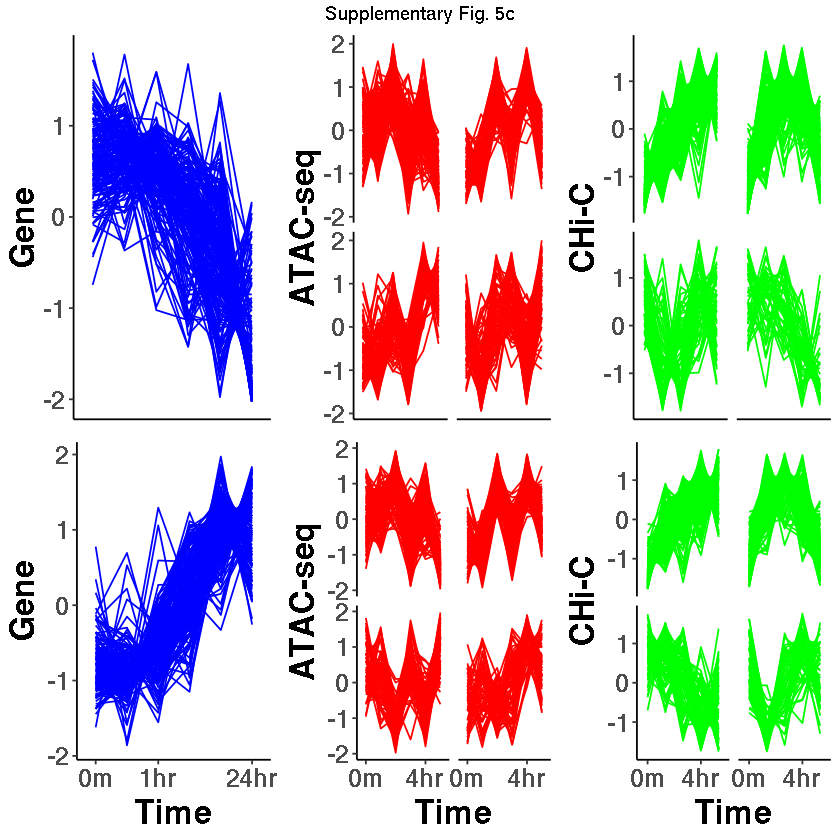

In [20]:

grid.arrange(p_gene1, p_atacseq1, p_chic1, p_gene2, p_atacseq2, p_chic2, ncol=3, top='Supplementary Fig. 5c')


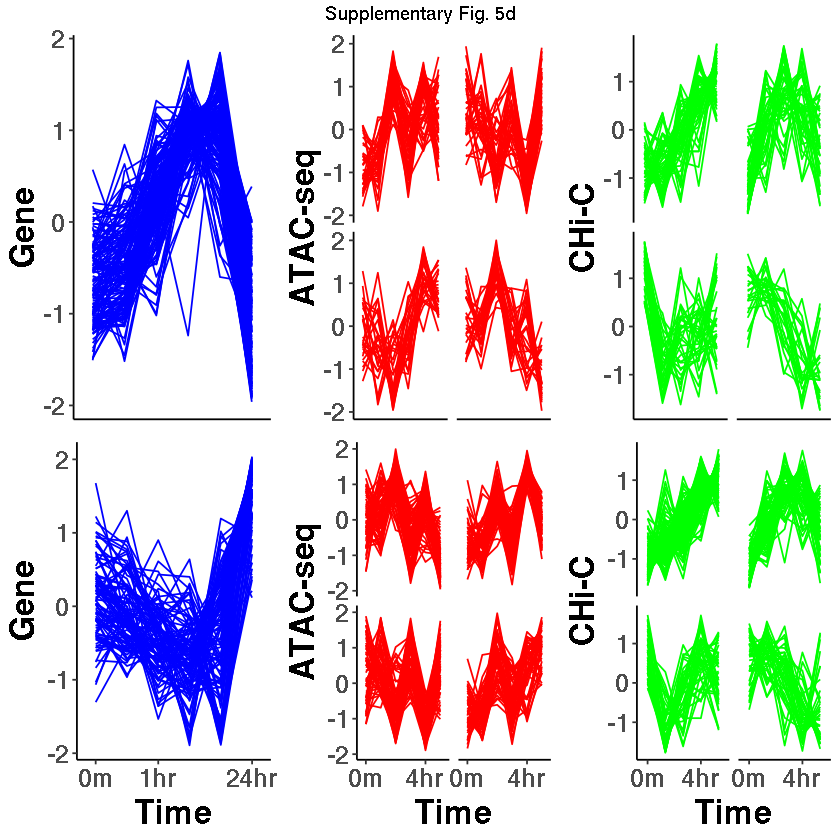

In [21]:
grid.arrange(p_gene3, p_atacseq3, p_chic3, p_gene4, p_atacseq4, p_chic4, ncol=3, top='Supplementary Fig. 5d')

### work on the case with static CHi-C and dynamic ATAC-seq

In [22]:
idx <- data_200k$BIC_chic>0 & data_200k$BIC_atacseq<0
data_200k_dynamicATAC <- data_200k[idx,]
time <- c('0m','20m','1hr','2hr','4hr','24hr') ### time points for the plotting

### clustering gene data first

In [23]:
data1_ENSG <- unique(data_200k_dynamicATAC[,c('ENSG',idx_gene)])
data1_gene <- data1_ENSG[,idx_gene]
data1_gene_normalized <- t(scale(t(data1_gene), center=TRUE, scale=TRUE))
data_cluster <- data1_gene_normalized

set.seed(5)
CLUSTER_SIZE = 4
kmeans_cluster <- kmeans(data_cluster,centers=CLUSTER_SIZE,iter.max = 100)
cluster_freq <- as.data.frame(table(kmeans_cluster$cluster))
names(cluster_freq) <- c('x','freq')
cl <- cluster_freq[with(cluster_freq,order(-cluster_freq[,'freq'])),]

stepsize <- 4
M <- kk:(kk+stepsize-1)
clusters_picked <- cl$x[M]
clusters_frequency <- cl$freq[M]
centers_picked <- kmeans_cluster$center[clusters_picked,]
idx <- numeric(0)

data_forillus <- numeric(0)
for (ii in 1:length(M)){
    idx <- which(kmeans_cluster$cluster==clusters_picked[ii]) 
    data_forillus <- c(data_forillus,c(t(data_cluster[idx,])))
}

### plotting gene clustering results

In [24]:
data_forplot <- data.frame(x=rep(time, sum(clusters_frequency)), y=data_forillus, 
                           group_time = rep(1:((sum(clusters_frequency))),each=length(time)),
                           group_cluster = rep(M,clusters_frequency*length(time)),
                           group_label = rep(c(rep('gene',6)), sum(clusters_frequency)),
                           group_frequency = rep(clusters_frequency, clusters_frequency*length(time)))

data_forplot$x_f <- factor(data_forplot$x, levels=c('0m','20m','1hr','2hr','4hr','24hr'))

p_gene1 <- ggplot(data=subset(data_forplot, data_forplot$group_cluster %in% '1'), aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_cluster)) + geom_line(color='blue')+
   labs(x ="Time", y = "Gene") + 
   theme(panel.background=element_blank(), axis.title.x=element_blank(),axis.text.x=element_blank(), axis.ticks.x=element_blank(), 
         axis.line=element_line(),strip.background = element_blank(), strip.text = element_blank(),
         axis.text.y=element_text(size=14, face='bold'),axis.title.y=element_text(size=18,face="bold"), legend.position="none") +
   facet_grid(.~group_label)

p_gene2 <- ggplot(data=subset(data_forplot, data_forplot$group_cluster %in% '2'), aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_cluster)) + geom_line(color='blue')+
   labs(x ="Time", y = "Gene") +  
   scale_x_discrete(breaks=c('0m','1hr','24hr'),labels=c("0m","1hr","24hr")) + 
   theme(panel.background=element_blank(), plot.title = element_text(hjust = 0.5, face='bold'), 
         axis.line=element_line(),strip.background = element_blank(), strip.text.x = element_blank(),
         axis.text=element_text(size=16, face='bold'),axis.title=element_text(size=18,face="bold"), legend.position="none") +
   facet_grid(.~group_label)

p_gene3 <- ggplot(data=subset(data_forplot, data_forplot$group_cluster %in% '3'), aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_cluster)) + geom_line(color='blue')+
   labs(x ="Time", y = "Gene") + 
   theme(panel.background=element_blank(), axis.title.x=element_blank(),axis.text.x=element_blank(), axis.ticks.x=element_blank(), 
         axis.line=element_line(),strip.background = element_blank(), strip.text = element_blank(),
         axis.text.y=element_text(size=14, face='bold'),axis.title.y=element_text(size=18,face="bold"), legend.position="none") +
   facet_grid(.~group_label)

p_gene4 <- ggplot(data=subset(data_forplot, data_forplot$group_cluster %in% '4'), aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_cluster)) + geom_line(color='blue')+
   labs(x ="Time", y = "Gene") + 
   scale_x_discrete(breaks=c('0m','1hr','24hr'),labels=c("0m","1hr","24hr")) + 
   theme(panel.background=element_blank(), plot.title = element_text(hjust = 0.5, face='bold'), 
         axis.line=element_line(),strip.background = element_blank(), strip.text.x = element_blank(),
         axis.text=element_text(size=16, face='bold'),axis.title=element_text(size=18,face="bold"), legend.position="none") +
   facet_grid(.~group_label)

### saving gene clustering results

In [25]:
data1_ENSG$gene_cluster <- kmeans_cluster$cluster

data_200k_dynamic_withgenecluster <- unique(merge(data1_ENSG[,c('ENSG','gene_cluster')], data_200k_dynamicATAC))
data_200k_dynamic_genecluster1 <- subset(data_200k_dynamic_withgenecluster, data_200k_dynamic_withgenecluster$gene_cluster %in% '1')
data_200k_dynamic_genecluster2 <- subset(data_200k_dynamic_withgenecluster, data_200k_dynamic_withgenecluster$gene_cluster %in% '2')
data_200k_dynamic_genecluster3 <- subset(data_200k_dynamic_withgenecluster, data_200k_dynamic_withgenecluster$gene_cluster %in% '3')
data_200k_dynamic_genecluster4 <- subset(data_200k_dynamic_withgenecluster, data_200k_dynamic_withgenecluster$gene_cluster %in% '4')


### clustering CHi-C data now

In [26]:
data1_chic_original1 <- unique(data_200k_dynamic_genecluster1[,c('baitID','otherEndID',idx_chic)])
data1_chic_original2 <- unique(data_200k_dynamic_genecluster2[,c('baitID','otherEndID',idx_chic)])
data1_chic_original3 <- unique(data_200k_dynamic_genecluster3[,c('baitID','otherEndID',idx_chic)])
data1_chic_original4 <- unique(data_200k_dynamic_genecluster4[,c('baitID','otherEndID',idx_chic)])

data1_chic1 <- data1_chic_original1[,idx_chic]
data1_chic2 <- data1_chic_original2[,idx_chic]
data1_chic3 <- data1_chic_original3[,idx_chic]
data1_chic4 <- data1_chic_original4[,idx_chic]

data1_chic1_normalized <- t(scale(t(data1_chic1), center=TRUE, scale=TRUE))
data1_chic2_normalized <- t(scale(t(data1_chic2), center=TRUE, scale=TRUE))
data1_chic3_normalized <- t(scale(t(data1_chic3), center=TRUE, scale=TRUE))
data1_chic4_normalized <- t(scale(t(data1_chic4), center=TRUE, scale=TRUE))

time_chic <- c('0m','20m','1hr','4hr','24hr')



### clustering and plotting CHi-C data

In [27]:
data_cluster_chic1 <- data1_chic1_normalized

set.seed(5)
CLUSTER_SIZE = 4
kmeans_cluster <- kmeans(data_cluster_chic1,centers=CLUSTER_SIZE,iter.max = 100)
cluster_freq <- as.data.frame(table(kmeans_cluster$cluster))
names(cluster_freq) <- c('x','freq')
cl <- cluster_freq[with(cluster_freq,order(-cluster_freq[,'freq'])),]

stepsize <- 4
kk <- 1
M <- kk:(kk+stepsize-1)
clusters_picked <- cl$x[M]
clusters_frequency <- cl$freq[M]
centers_picked <- kmeans_cluster$center[clusters_picked,]
idx <- numeric(0)

data_forillus <- numeric(0)
    
for (ii in 1:length(M)){
    idx <- which(kmeans_cluster$cluster==clusters_picked[ii]) 
    data_forillus <- c(data_forillus,c(t(data_cluster_chic1[idx,])))
}

data_forplot <- data.frame(x=rep(time_chic, sum(clusters_frequency)), y=data_forillus, 
                           group_time = rep(1:((sum(clusters_frequency))),each=length(time_chic)),
                           group_cluster = rep(M,clusters_frequency*length(time_chic)),
                           group_label = rep(c(rep('CHi-C',length(time_chic))), sum(clusters_frequency)),
                           group_frequency = rep(clusters_frequency, clusters_frequency*length(time_chic)))
data_forplot$x_f <- factor(data_forplot$x, levels=c('0m','20m','1hr','4hr','24hr'))


p_chic1 <- ggplot(data=data_forplot, aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_label)) + geom_line(color='green')+
   labs( x ="Time", y = "CHi-C") + 
   scale_x_discrete(breaks=c('0m','4hr'),labels=c("0m","4hr")) + 
   theme(panel.background=element_blank(), axis.title.x=element_blank(),axis.text.x=element_blank(), axis.ticks.x=element_blank(), 
         axis.line=element_line(),strip.background = element_blank(), strip.text = element_blank(),
         axis.text.y=element_text(size=14, face='bold'),axis.title.y=element_text(size=18,face="bold"), legend.position="none") +
   facet_wrap(group_cluster~., ncol=2)

data_cluster_chic2 <- data1_chic2_normalized

set.seed(5)
CLUSTER_SIZE = 4
kmeans_cluster <- kmeans(data_cluster_chic2,centers=CLUSTER_SIZE,iter.max = 100)
cluster_freq <- as.data.frame(table(kmeans_cluster$cluster))
names(cluster_freq) <- c('x','freq')
cl <- cluster_freq[with(cluster_freq,order(-cluster_freq[,'freq'])),]

stepsize <- 4
M <- kk:(kk+stepsize-1)
clusters_picked <- cl$x[M]
clusters_frequency <- cl$freq[M]
centers_picked <- kmeans_cluster$center[clusters_picked,]
idx <- numeric(0)

data_forillus <- numeric(0)
    
for (ii in 1:length(M)){
    idx <- which(kmeans_cluster$cluster==clusters_picked[ii]) 
    data_forillus <- c(data_forillus,c(t(data_cluster_chic2[idx,])))
}


data_forplot <- data.frame(x=rep(time_chic, sum(clusters_frequency)), y=data_forillus, 
                           group_time = rep(1:((sum(clusters_frequency))),each=length(time_chic)),
                           group_cluster = rep(M,clusters_frequency*length(time_chic)),
                           group_label = rep(c(rep('CHiC',length(time_chic))), sum(clusters_frequency)),
                           group_frequency = rep(clusters_frequency, clusters_frequency*length(time_chic)))
data_forplot$x_f <- factor(data_forplot$x, levels=c('0m','20m','1hr','4hr','24hr'))


p_chic2 <- ggplot(data=data_forplot, aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_label)) + geom_line(color='green')+
   labs( x ="Time", y = "CHi-C") + 
   scale_x_discrete(breaks=c('0m','4hr'),labels=c("0m","4hr")) + 
theme(panel.background=element_blank(), plot.title = element_text(hjust = 0.5, face='bold'), 
         axis.line=element_line(),strip.background = element_blank(), strip.text.x = element_blank(),
         axis.text=element_text(size=16, face='bold'),axis.title=element_text(size=18,face="bold"), legend.position="none") +   #facet_grid((group_cluster-1) %/%2 ~(group_cluster-1)%%2 )
   facet_wrap(group_cluster~., ncol=2)

data_cluster_chic3 <- data1_chic3_normalized

set.seed(5)
CLUSTER_SIZE = 4
kmeans_cluster <- kmeans(data_cluster_chic3,centers=CLUSTER_SIZE,iter.max = 100)
cluster_freq <- as.data.frame(table(kmeans_cluster$cluster))
names(cluster_freq) <- c('x','freq')
cl <- cluster_freq[with(cluster_freq,order(-cluster_freq[,'freq'])),]

stepsize <- 4
M <- kk:(kk+stepsize-1)
clusters_picked <- cl$x[M]
clusters_frequency <- cl$freq[M]
centers_picked <- kmeans_cluster$center[clusters_picked,]
idx <- numeric(0)

data_forillus <- numeric(0)
    
for (ii in 1:length(M)){
    idx <- which(kmeans_cluster$cluster==clusters_picked[ii]) 
    data_forillus <- c(data_forillus,c(t(data_cluster_chic3[idx,])))
}


data_forplot <- data.frame(x=rep(time_chic, sum(clusters_frequency)), y=data_forillus, 
                           group_time = rep(1:((sum(clusters_frequency))),each=length(time_chic)),
                           group_cluster = rep(M,clusters_frequency*length(time_chic)),
                           group_label = rep(c(rep('CHi-C',length(time_chic))), sum(clusters_frequency)),
                           group_frequency = rep(clusters_frequency, clusters_frequency*length(time_chic)))
data_forplot$x_f <- factor(data_forplot$x, levels=c('0m','20m','1hr','4hr','24hr'))


p_chic3 <- ggplot(data=data_forplot, aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_label)) + geom_line(color='green')+
   labs( x ="Time", y = "CHi-C") + 
   scale_x_discrete(breaks=c('0m','4hr'),labels=c("0m","4hr")) + 
   theme(panel.background=element_blank(), axis.title.x=element_blank(),axis.text.x=element_blank(), axis.ticks.x=element_blank(), 
         axis.line=element_line(),strip.background = element_blank(), strip.text = element_blank(),
         axis.text.y=element_text(size=14, face='bold'),axis.title.y=element_text(size=18,face="bold"), legend.position="none") +
   facet_wrap(group_cluster~., ncol=2)

data_cluster_chic4 <- data1_chic4_normalized

set.seed(5)
CLUSTER_SIZE = 4
kmeans_cluster <- kmeans(data_cluster_chic4,centers=CLUSTER_SIZE,iter.max = 100)
cluster_freq <- as.data.frame(table(kmeans_cluster$cluster))
names(cluster_freq) <- c('x','freq')
cl <- cluster_freq[with(cluster_freq,order(-cluster_freq[,'freq'])),]

stepsize <- 4
M <- kk:(kk+stepsize-1)
clusters_picked <- cl$x[M]
clusters_frequency <- cl$freq[M]
centers_picked <- kmeans_cluster$center[clusters_picked,]
idx <- numeric(0)

data_forillus <- numeric(0)
    
for (ii in 1:length(M)){
    idx <- which(kmeans_cluster$cluster==clusters_picked[ii]) 
    data_forillus <- c(data_forillus,c(t(data_cluster_chic4[idx,])))
}


data_forplot <- data.frame(x=rep(time_chic, sum(clusters_frequency)), y=data_forillus, 
                           group_time = rep(1:((sum(clusters_frequency))),each=length(time_chic)),
                           group_cluster = rep(M,clusters_frequency*length(time_chic)),
                           group_label = rep(c(rep('CHi-C',length(time_chic))), sum(clusters_frequency)),
                           group_frequency = rep(clusters_frequency, clusters_frequency*length(time_chic)))
data_forplot$x_f <- factor(data_forplot$x, levels=c('0m','20m','1hr','4hr','24hr'))


p_chic4 <- ggplot(data=data_forplot, aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_label)) + geom_line(color='green')+
   labs( x ="Time", y = "CHi-C") + 
   scale_x_discrete(breaks=c('0m','4hr'),labels=c("0m","4hr")) + 
theme(panel.background=element_blank(), plot.title = element_text(hjust = 0.5, face='bold'), 
         axis.line=element_line(),strip.background = element_blank(), strip.text.x = element_blank(),
         axis.text=element_text(size=16, face='bold'),axis.title=element_text(size=18,face="bold"), legend.position="none") +   #facet_grid((group_cluster-1) %/%2 ~(group_cluster-1)%%2 )
   facet_wrap(group_cluster~., ncol=2)

### clustering and plotting relevant ATAC-seq data

In [28]:


data1_original <- unique(data_200k_dynamic_genecluster1[, c('ID',idx_atacseq)])
data1 <- data1_original
data1_atacseq <- data1[,idx_atacseq]
data1_atacseq_normalized <- t(scale(t(data1_atacseq), center=TRUE, scale=TRUE))
data_cluster <- data1_atacseq_normalized

set.seed(5)
CLUSTER_SIZE = 6
kmeans_cluster <- kmeans(data_cluster,centers=CLUSTER_SIZE,iter.max = 100)
cluster_freq <- as.data.frame(table(kmeans_cluster$cluster))
names(cluster_freq) <- c('x','freq')
cl <- cluster_freq[with(cluster_freq,order(-cluster_freq[,'freq'])),]

stepsize <- 4
M <- kk:(kk+stepsize-1)
clusters_picked <- cl$x[M]
clusters_frequency <- cl$freq[M]
centers_picked <- kmeans_cluster$center[clusters_picked,]
idx <- numeric(0)

data_forillus <- numeric(0)
data_ENSG <- character(0)
    
time <- c('0m','20m','1hr','2hr','4hr','24hr')
for (ii in 1:length(M)){
    idx <- which(kmeans_cluster$cluster==clusters_picked[ii]) 
    data_forillus <- c(data_forillus,c(t(data_cluster[idx,])))
}


data_forplot <- data.frame(x=rep(time, sum(clusters_frequency)), y=data_forillus, 
                           group_time = rep(1:((sum(clusters_frequency))),each=length(time)),
                           group_cluster = rep(M,clusters_frequency*length(time)),
                           group_label = rep(c(rep('atacseq',6)), sum(clusters_frequency)),
                           group_frequency = rep(clusters_frequency, clusters_frequency*length(time)))
data_forplot$x_f <- factor(data_forplot$x, levels=c('0m','20m','1hr','2hr','4hr','24hr'))


p_atacseq1 <- ggplot(data=data_forplot, aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_label)) + geom_line(color='red')+
   labs( x ="Time", y = "ATAC-seq") + 
   theme(panel.background=element_blank(), axis.title.x=element_blank(),axis.text.x=element_blank(), axis.ticks.x=element_blank(), 
         axis.line=element_line(),strip.background = element_blank(), strip.text = element_blank(),
         axis.text.y=element_text(size=14, face='bold'),axis.title.y=element_text(size=18,face="bold"), legend.position="none") +
   facet_wrap(group_cluster~., ncol=2)

data1_original <- unique(data_200k_dynamic_genecluster2[, c('ID',idx_atacseq)])
data1 <- data1_original
data1_atacseq <- data1[,idx_atacseq]
data1_atacseq_normalized <- t(scale(t(data1_atacseq), center=TRUE, scale=TRUE))
data_cluster <- data1_atacseq_normalized

set.seed(5)
CLUSTER_SIZE = 6
kmeans_cluster <- kmeans(data_cluster,centers=CLUSTER_SIZE,iter.max = 100)
cluster_freq <- as.data.frame(table(kmeans_cluster$cluster))
names(cluster_freq) <- c('x','freq')
cl <- cluster_freq[with(cluster_freq,order(-cluster_freq[,'freq'])),]

stepsize <- 4
M <- kk:(kk+stepsize-1)
clusters_picked <- cl$x[M]
clusters_frequency <- cl$freq[M]
centers_picked <- kmeans_cluster$center[clusters_picked,]
idx <- numeric(0)

data_forillus <- numeric(0)
data_ENSG <- character(0)
    
time <- c('0m','20m','1hr','2hr','4hr','24hr')
for (ii in 1:length(M)){
    idx <- which(kmeans_cluster$cluster==clusters_picked[ii]) 
    data_forillus <- c(data_forillus,c(t(data_cluster[idx,])))
}


data_forplot <- data.frame(x=rep(time, sum(clusters_frequency)), y=data_forillus, 
                           group_time = rep(1:((sum(clusters_frequency))),each=length(time)),
                           group_cluster = rep(M,clusters_frequency*length(time)),
                           group_label = rep(c(rep('atacseq',6)), sum(clusters_frequency)),
                           group_frequency = rep(clusters_frequency, clusters_frequency*length(time)))

data_forplot$x_f <- factor(data_forplot$x, levels=c('0m','20m','1hr','2hr','4hr','24hr'))

p_atacseq2 <- ggplot(data=data_forplot, aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_label)) + geom_line(color='red')+
   labs( x ="Time", y = "ATAC-seq") +  
   scale_x_discrete(breaks=c('0m','4hr'),labels=c("0m","4hr")) + 
theme(panel.background=element_blank(), plot.title = element_text(hjust = 0.5, face='bold'), 
         axis.line=element_line(),strip.background = element_blank(), strip.text.x = element_blank(),
         axis.text=element_text(size=16, face='bold'),axis.title=element_text(size=18,face="bold"), legend.position="none") +   #facet_grid((group_cluster-1) %/%2 ~(group_cluster-1)%%2 )
   facet_wrap(group_cluster~., ncol=2)

data1_original <- unique(data_200k_dynamic_genecluster3[, c('ID',idx_atacseq)])
data1 <- data1_original
data1_atacseq <- data1[,idx_atacseq]
data1_atacseq_normalized <- t(scale(t(data1_atacseq), center=TRUE, scale=TRUE))
data_cluster <- data1_atacseq_normalized

set.seed(5)
CLUSTER_SIZE = 6
kmeans_cluster <- kmeans(data_cluster,centers=CLUSTER_SIZE,iter.max = 100)
cluster_freq <- as.data.frame(table(kmeans_cluster$cluster))
names(cluster_freq) <- c('x','freq')
cl <- cluster_freq[with(cluster_freq,order(-cluster_freq[,'freq'])),]

stepsize <- 4
M <- kk:(kk+stepsize-1)
clusters_picked <- cl$x[M]
clusters_frequency <- cl$freq[M]
centers_picked <- kmeans_cluster$center[clusters_picked,]
idx <- numeric(0)

data_forillus <- numeric(0)
data_ENSG <- character(0)
    
time <- c('0m','20m','1hr','2hr','4hr','24hr')
for (ii in 1:length(M)){
    idx <- which(kmeans_cluster$cluster==clusters_picked[ii]) 
    data_forillus <- c(data_forillus,c(t(data_cluster[idx,])))
}


data_forplot <- data.frame(x=rep(time, sum(clusters_frequency)), y=data_forillus, 
                           group_time = rep(1:((sum(clusters_frequency))),each=length(time)),
                           group_cluster = rep(M,clusters_frequency*length(time)),
                           group_label = rep(c(rep('atacseq',6)), sum(clusters_frequency)),
                           group_frequency = rep(clusters_frequency, clusters_frequency*length(time)))

data_forplot$x_f <- factor(data_forplot$x, levels=c('0m','20m','1hr','2hr','4hr','24hr'))

p_atacseq3 <- ggplot(data=data_forplot, aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_label)) + geom_line(color='red')+
   labs( x ="Time", y = "ATAC-seq") + 
   scale_x_discrete(breaks=c('0m','4hr'),labels=c("0m","4hr")) + 
   theme(panel.background=element_blank(), axis.title.x=element_blank(),axis.text.x=element_blank(), axis.ticks.x=element_blank(), 
         axis.line=element_line(),strip.background = element_blank(), strip.text = element_blank(),
         axis.text.y=element_text(size=14, face='bold'),axis.title.y=element_text(size=18,face="bold"), legend.position="none") +
   facet_wrap(group_cluster~., ncol=2)


data1_original <- unique(data_200k_dynamic_genecluster4[, c('ID',idx_atacseq)])
data1 <- data1_original
data1_atacseq <- data1[,idx_atacseq]
data1_atacseq_normalized <- t(scale(t(data1_atacseq), center=TRUE, scale=TRUE))
data_cluster <- data1_atacseq_normalized

set.seed(5)
CLUSTER_SIZE = 6
kmeans_cluster <- kmeans(data_cluster,centers=CLUSTER_SIZE,iter.max = 100)
cluster_freq <- as.data.frame(table(kmeans_cluster$cluster))
names(cluster_freq) <- c('x','freq')
cl <- cluster_freq[with(cluster_freq,order(-cluster_freq[,'freq'])),]

stepsize <- 4
M <- kk:(kk+stepsize-1)
clusters_picked <- cl$x[M]
clusters_frequency <- cl$freq[M]
centers_picked <- kmeans_cluster$center[clusters_picked,]
idx <- numeric(0)

data_forillus <- numeric(0)
data_ENSG <- character(0)
    
time <- c('0m','20m','1hr','2hr','4hr','24hr')
for (ii in 1:length(M)){
    idx <- which(kmeans_cluster$cluster==clusters_picked[ii]) 
    data_forillus <- c(data_forillus,c(t(data_cluster[idx,])))
}


data_forplot <- data.frame(x=rep(time, sum(clusters_frequency)), y=data_forillus, 
                           group_time = rep(1:((sum(clusters_frequency))),each=length(time)),
                           group_cluster = rep(M,clusters_frequency*length(time)),
                           group_label = rep(c(rep('atacseq',6)), sum(clusters_frequency)),
                           group_frequency = rep(clusters_frequency, clusters_frequency*length(time)))

data_forplot$x_f <- factor(data_forplot$x, levels=c('0m','20m','1hr','2hr','4hr','24hr'))

p_atacseq4 <- ggplot(data=data_forplot, aes(x=x_f,y=y,group=interaction(group_time, group_label), color=group_label)) + geom_line(color='red')+
   labs( x ="Time", y = "ATAC-seq") + 
   scale_x_discrete(breaks=c('0m','4hr'),labels=c("0m","4hr")) + 
theme(panel.background=element_blank(), plot.title = element_text(hjust = 0.5, face='bold'), 
         axis.line=element_line(),strip.background = element_blank(), strip.text.x = element_blank(),
         axis.text=element_text(size=16, face='bold'),axis.title=element_text(size=18,face="bold"), legend.position="none") +   #facet_grid((group_cluster-1) %/%2 ~(group_cluster-1)%%2 )
   facet_wrap(group_cluster~., ncol=2)



### put results together and plot them

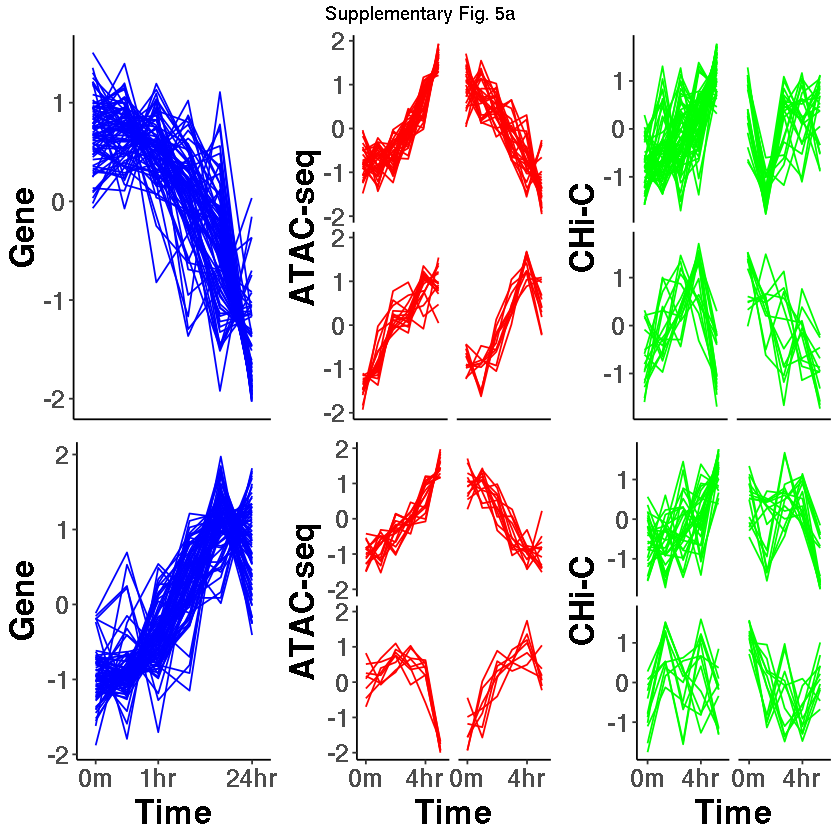

In [29]:

grid.arrange(p_gene1, p_atacseq1, p_chic1, p_gene2, p_atacseq2, p_chic2, ncol=3, top = 'Supplementary Fig. 5a')


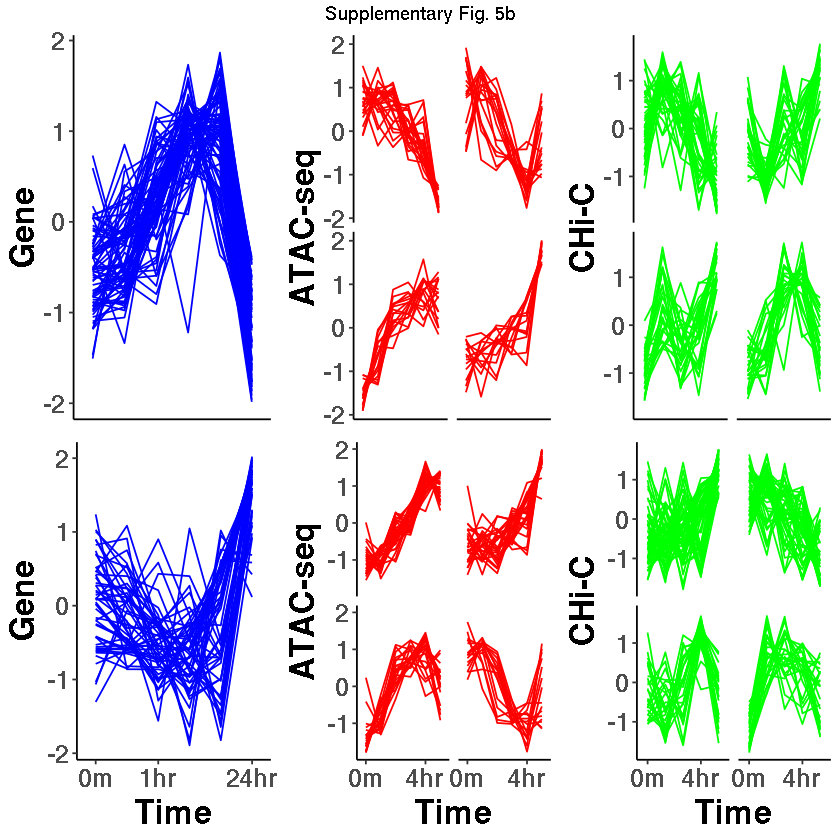

In [30]:
grid.arrange(p_gene3, p_atacseq3, p_chic3, p_gene4, p_atacseq4, p_chic4, ncol=3, top = 'Supplementary Fig. 5b')